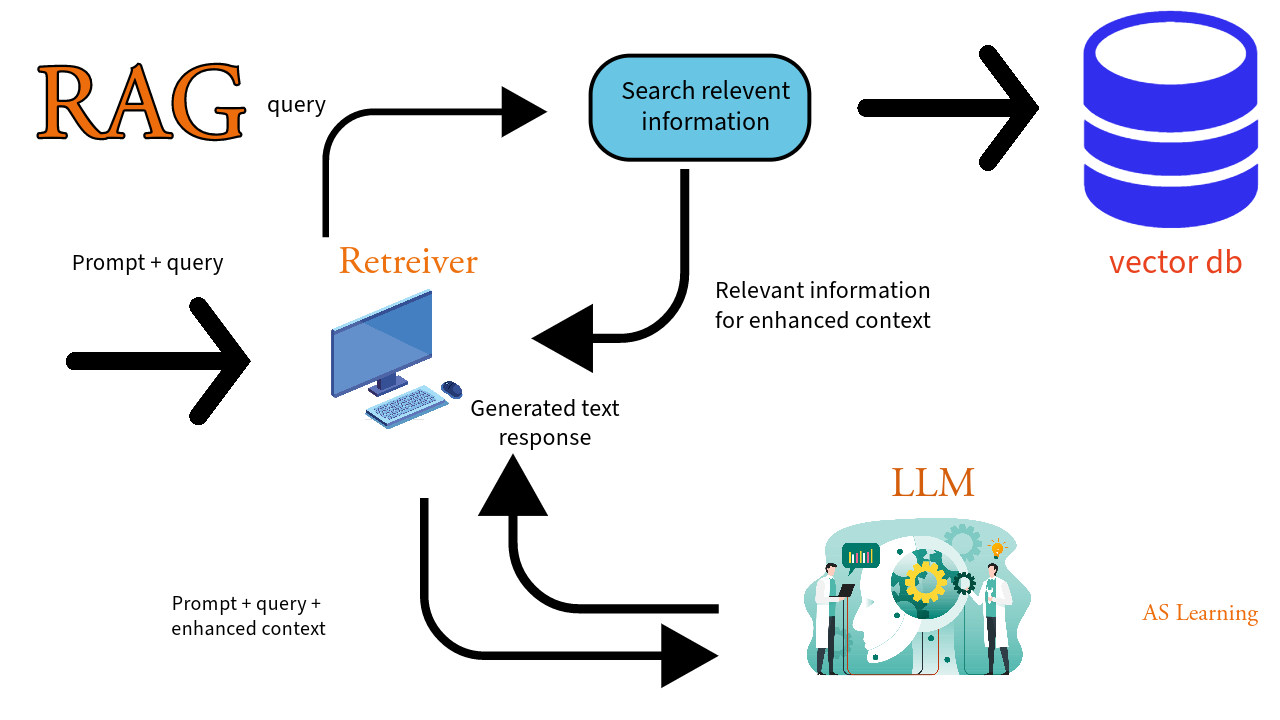

In [59]:
import requests
import re
def generate_queries_chatgpt(original_query):
    payload = {
      "question": original_query,
      "company": "Luxe Residential",
      "domain": "Real estate"
    }
    
    response = requests.post("http://46.43.144.145:7010/variation_rag",json = payload)
    
    variation_text = response.json()
    
    pattern = r'\d+\.\s(.*?)\?'
    # Find all matches using re.findall
    generated_queries = re.findall(pattern, variation_text)
    
    return generated_queries

In [60]:
generate_queries_chatgpt('what is your address?')

['Where is your location',
 'Can you provide me with your mailing address',
 'What is the physical address of your property',
 'In what geographic area can I find you']

In [48]:
with open('luxe.txt') as f:
    worktual_text=f.read()

In [6]:
# from semantic_text_splitter import HuggingFaceTextSplitter
# from tokenizers import Tokenizer

# # Maximum number of tokens in a chunk
# # max_characters = 300
# # Optionally can also have the splitter not trim whitespace for you
# tokenizer = Tokenizer.from_pretrained("bert-base-uncased")
# splitter = HuggingFaceTextSplitter(tokenizer, trim_chunks=False)

# sentences = splitter.chunks(worktual_text, 50)

# # i  = 0
# result_chunks = []
# current_chunk = ""
# for i in range(len(sentences)):
#     current_chunk += f" {sentences[i]}"
#     if current_chunk.count(" ") >= 300:
#         result_chunks.append(current_chunk)
#         # print(current_chunk)
#         current_chunk = f"{sentences[i-2]} {sentences[i-1]} {sentences[i]}"
# # all_documents = {}  
# # for i in range(len(result_chunks)):
# #     all_documents[f"doc{i}"] = result_chunks[i]
                  
# # print(all_documents)
    

/home/vectone/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
from semantic_text_splitter import CharacterTextSplitter

# Optionally can also have the splitter trim whitespace for you
splitter = CharacterTextSplitter()

# Maximum number of characters in a chunk. Will fill up the
# chunk until it is somewhere in this range.
result_chunks = splitter.chunks(worktual_text, chunk_capacity=(500, 1000))

In [50]:
len(result_chunks)

282

In [51]:
import llama_index
from llama_index import VectorStoreIndex
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.embeddings import HuggingFaceEmbedding
import requests

In [52]:
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-large-en",device="cuda")
# embed_model = HuggingFaceEmbedding(model_name="jinaai/jina-embeddings-v2-base-en",device="cuda")

service_context = ServiceContext.from_defaults(embed_model=embed_model,llm = None)
documents = [llama_index.Document(text = i) for i in result_chunks]
print(len(documents))
index = VectorStoreIndex.from_documents(documents=documents,service_context=service_context)



LLM is explicitly disabled. Using MockLLM.
282


In [61]:

def get_context(query):
    
    before_reranking={}
    retriever = llama_index.indices.vector_store.retrievers.VectorIndexRetriever(
                index=index,
                similarity_top_k=4
    )  
    result = retriever.retrieve(query)

    cnt = 0
    try:
        for i in range(4):
            before_reranking[result[i].node.text] = result[i].score
            cnt+=1
    except:
        print("no of chunks from web------------------------------> ",cnt)
        cnt = 0
            
    return before_reranking


In [10]:
# get_context("tell me about worktual")

In [11]:
# # Function to generate queries using OpenAI's ChatGPT
# def generate_queries_chatgpt(original_query):

#     response = openai.ChatCompletion.create(
#         model="gpt-3.5-turbo",
#         messages=[
#             {"role": "system", "content": "You are a helpful assistant that generates multiple search queries based on a single input query."},
#             {"role": "user", "content": f"Generate multiple search queries related to: {original_query}"},
#             {"role": "user", "content": "OUTPUT (4 queries):"}
#         ]
#     )

#     generated_queries = response.choices[0]["message"]["content"].strip().split("\n")
#     return generated_queries

In [12]:
# # Mock function to simulate vector search, returning random scores
# def vector_search(query, all_documents):
#     available_docs = list(all_documents.keys())
#     random.shuffle(available_docs)
#     selected_docs = available_docs[:random.randint(2, 5)]
#     scores = {doc: round(random.uniform(0.7, 0.9), 2) for doc in selected_docs}
#     print({doc: score for doc, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)})
#     return {doc: score for doc, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)}

In [62]:
# Reciprocal Rank Fusion algorithm
def reciprocal_rank_fusion(search_results_dict, k=60):
    fused_scores = {}
#     print("Initial individual search result ranks:")
#     for query, doc_scores in search_results_dict.items():
# #         print(f"For query '{query}': {doc_scores}")

    for query, doc_scores in search_results_dict.items():
#         print(query,doc_scores)
        for rank, (doc, score) in enumerate(sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)):
#             print(rank,doc,score)
            if doc not in fused_scores:
                fused_scores[doc] = 0
            previous_score = fused_scores[doc]
            #print(fused_scores[doc])
            fused_scores[doc] += 1 / (rank + k)
#             print(f"Updating score for {doc} from {previous_score} to {fused_scores[doc]} based on rank {rank} in query '{query}'")

    reranked_results = {doc: score for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)}
#     print("Final reranked results:", reranked_results)
    return reranked_results

In [14]:
# # Dummy function to simulate generative output
# def generate_output(reranked_results, queries):
#     return f"Final output based on {queries} and reranked documents: {list(reranked_results.keys())}"

In [10]:
import random

In [16]:
# # # Predefined set of documents (usually these would be from your search database)
# # all_documents = {
# #     "doc1": "Climate change and economic impact.",
# #     "doc2": "Public health concerns due to climate change.",
# #     "doc3": "Climate change: A social perspective.",
# #     "doc4": "Technological solutions to climate change.",
# #     "doc5": "Policy changes needed to combat climate change.",
# #     "doc6": "Climate change and its impact on biodiversity.",
# #     "doc7": "Climate change: The science and models.",
# #     "doc8": "Global warming: A subset of climate change.",
# #     "doc9": "How climate change affects daily weather.",
# #     "doc10": "The history of climate change activism."
# # }

# # Main function
# if __name__ == "__main__":
#     original_query = "your contact number"
#     generated_queries = generate_queries_chatgpt(original_query)

#     all_results = {}
#     for query in generated_queries:
#         search_results = vector_search(query, all_documents)
#         all_results[query] = search_results

#     reranked_results = reciprocal_rank_fusion(all_results)

#     final_output = generate_output(reranked_results, generated_queries)

#     print(final_output)

In [98]:
query ="what are the services of landlords"
variation_input = generate_queries_chatgpt(query)
generated_queries= variation_input+[query]

all_results = {}
for query in generated_queries:
    search_results = get_context(query)
    all_results[query] = search_results


reranked_results = reciprocal_rank_fusion(all_results)

final_context = ""
count = 0
for i,j in reranked_results.items():
#     print(f"{i}:{j}\n\n")
    final_context += i
    count +=1
    if count==7:
        break
        
# print(final_context)

In [99]:
import datetime

current_date = datetime.datetime.now()

payload = {
  "message_content": query,
  "content": final_context,
  "company_name": "Luxe Residential",
  "domain": "Real estate"
}

response = requests.post("http://46.43.144.145:7010/rulebased_bot",json=payload)

print(response.json())

We provide various services to help landlords manage their properties, such as maintenance issues, quotes and repairs, routine property inspections for peace of mind, assistance with NRL Numbers for overseas landlords, preparing the home for rental by optimizing it and creating a good first impression. We also offer marketing support when renting out your property. Additionally, we can handle inventory management during tenancy termination and ensure compliance with safety regulations. Our team is available to guide you through different service options like Letting Agreed (Tenant Find), Rent Collection (Tenant Find & Rent Collection) or letting only where you are more involved in managing your property's day-to-day operations.


In [79]:
# resposne = requests.post("http://46.43.144.145:7010/informative_webscrap",json={"text":final_context})
# meaningfull_data = resposne.json()["response"]
# print(meaningfull_data)

In [69]:
 final_context

In [45]:
all_documents['doc2']

'Mr M Simmonds, Harlow, CM17 (Landlord) Recently Adam let one of my properties within hours Luxe Estate agents are refreshing straight-talking property consultants who simply and efficiently get the job done.  Recently Adam let one of my properties within hours I am really impressed with the level of service I received. I have submitted my entire residential and commercial portfolio under their professional care.  Mr C Nicols, Epping, CM16 A very smooth and professional service A very smooth and professional service.  I was kept up to date at all times and the staff always seemed on the front foot, which has not always formed part of my experience when dealing with other agents. Would highly recommend to others.  Mrs R Thapa, South Woodford, E18 They kept to their promise and delivered a quick pain-free sale Adam and Aimee made contact with myself and my husband throughout the process making the sale hassle free for us both. '

In [52]:
vector_search(query, all_documents)

{'doc878': 0.87, 'doc923': 0.78, 'doc1176': 0.75, 'doc868': 0.74, 'doc1152': 0.73}


{'doc878': 0.87,
 'doc923': 0.78,
 'doc1176': 0.75,
 'doc868': 0.74,
 'doc1152': 0.73}